In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple, defaultdict

In [2]:
#the jig is a half-line. It extends infinitely in one direction
#the state includes the displacement (signed distance) from the object to the jig

#   |---> (positive displacement)
#   o   jjjjjj...
# -------->  (coordinate frame attached to object)

# in 1D, you can't rotate the object, so the object frame positive x axis always points to the left
# whether you're plotting in world frame or object frame
#       <---| (negative displacement)
# ..jjjj   o
#  --------> (coordinate frame attached to object)

# HOWEVER, if we attach a coordinate frame to the jig, such that 0 is the boundary, 
# and the negative direction is occupied by jig, then in this coordinate frame, 
# the displacment to the object is always positive
# BUT now we need to encode whether the object frame points left or right,
# since that's the frame you can specify the actions in.
# (I think this is actually less obvious in 1D than in higher dimensions)

# To make the case analogous with the x, y, \theta case consider the following state space

$\left( \mathbf{R}_{+} \times \mathbf{\theta} \right) \cup \mathbf{C}$

$\theta$ in the 1D case takes on one of two values. $\mathbf{C}$ is binary-valued and says whether you're in contact or not. In this 1D case, there is only one contact manifold, and it's zero dimensional.

One departure from the 2D case is that you can't really transition from one $\theta$ value to the other. However, it's still necessary to include it in the state, because in a ($\theta=0^\circ$) world, taking a step in the positive direction increases the displacement from the jig. In a ($\theta=180^\circ$) world, taking a a step in the positive direction *decreases* the displacement.

For comparison, the plannar domain we're considering has the following state space:

$\left( \mathbf{R}_{+} \times \mathbf{R}_{+} \times \mathbf{\theta} \right) 
\cup \left( \mathbf{R}_{+} \times \mathbf{\theta} \right)
\cup \left( \mathbf{R}_{+} \times \mathbf{\theta} \right)
\cup \left( \mathbf{\theta} \right)
\cup \mathbf{C}$

(I'm being informal in writing $\theta$. It really is $SO(2)$)

The space correspond, in order, to:
- the no-contact manifold
- contact with one arm of the jig
- contact with the other arm of the jig
- contact with both arms of the jig
- and the questionably the double-edge contact with the square object is in the corner of the jig

The non-negativity on the real coordinates are applicable when you take the state to be the pose of the object expressed in the jig frame. If you take the pose of the jig expressed in the object frame, then you can't say the coordinates are non-negative

Actually, let us use this state space
$\left( \mathbf{R}_{+} \cup \mathbf{C} \right)\times \mathbf{\theta}$

When we are up against the contact, which of the following is true?
- moving in the positive direction will further push into the contact
- moving in the positive direction will break contact

$\theta$ tells us.

The state space actually is a subset of $\left(\mathbf{R} \cup \mathbf{C} \cup \mathbf{V}\right) \times \mathbf{\theta}$.

But only a subset of those states make sense in the case that the jig is truly a half-line. In the object frame, the jig may have a postive position, but it then must be facing in the negative direction (the jig extends outward toward $+\infty$)

In [3]:
# I am crazy to do this. But this prevents rogue types from being generated (like DirectionStateFactor(3.2))
# And also allows these to be used as dict keys (they are immutable)

#What it doesn't let me do is make a type hierarchy that well.

DirectionStateFactorBase = namedtuple("DirectionStateFactor", ["d"])
class DirectionStateFactor(DirectionStateFactorBase):
    def __new__(cls, d):    
        if d == 1:
            _d = 1
        elif d == -1:
            _d = -1
        else:
            raise ValueError("direction: %s"%d)

        self = super(DirectionStateFactor, cls).__new__(cls, d)
        return self

    def __repr__(self):
        return "Direction: %s"%(self.d)

DisplacementStateFactor = namedtuple("DisplacementStateFactor", []) #"abstract" type

MetricStateFactorBase = namedtuple("MetricStateFactor", ["x"])
class MetricStateFactor(MetricStateFactorBase):
    def __new__(cls, x):
        assert(x%1 == 0) #it's an index into some discretization
        self = super(MetricStateFactor, cls).__new__(cls, x)
        return self

    def __repr__(self):
        return "Metric: %s"%(self.x)

class VoidStateFactor(DisplacementStateFactor):
    def __new__(cls):
        self = super(VoidStateFactor, cls).__new__(cls)
        return self

    def __eq__(self, other):
        return self.__class__ == other.__class__
    
    def __repr__(self):
        return "Void"

class ContactStateFactor(DisplacementStateFactor):
    def __new__(cls):
        self = super(ContactStateFactor, cls).__new__(cls)
        return self

    def __eq__(self, other):
        return self.__class__ == other.__class__
    
    def __repr__(self):
        return "Contact"

#I don't want them to inherit the equality method. and I was the hashing to be unique.
assert( not (ContactStateFactor() == VoidStateFactor() ) )

StateBase = namedtuple("State", ["direction", "displacement"])
    
class State(StateBase):
    def __new__(cls, direction_factor, displacement_factor):
        assert(isinstance(direction_factor, DirectionStateFactor))
        assert(isinstance(displacement_factor, MetricStateFactor) or #this line would have been avoided if I figured out subclassing
              isinstance(displacement_factor, DisplacementStateFactor))
        self = super(State, cls).__new__(cls, direction_factor, displacement_factor)
        return self

    def __repr__(self):
        return "State: " + ("+" if self.direction.d==1 else "-") + self.displacement.__repr__()

class StateSpace(object):
    def __init__(self, extent=1.0, d_xy=0.01, object_half_width=0.0636):
        self.extent = extent
        self.d_xy = d_xy
        self.object_half_width = object_half_width
        
        self.extent_grid = int(np.ceil(self.extent/self.d_xy))
        object_half_width_grid = int(np.floor(object_half_width/d_xy))
        
        self.discretization_free = np.concatenate(
            [np.arange(-self.extent_grid, -object_half_width_grid+1),
            np.arange(object_half_width_grid, self.extent_grid+1)]) * d_xy
        
        # negative positions have a +1 direction, and vice versa
        self.n_directions = 2
        
        self.others_displacement = [ContactStateFactor, VoidStateFactor]
        self.n_states = len(self.discretization_free) + (len(self.others_displacement))*self.n_directions
        
        self.manifold_1d = set()
        self.manifold_0d = set()
        
        for d in [DirectionStateFactor(-1), DirectionStateFactor(+1)]:
            self.manifold_0d.add( State(d, ContactStateFactor()) )
            self.manifold_0d.add( State(d, VoidStateFactor()) )

        for i in range(len(self.discretization_free)):
            self.manifold_1d.add(
                State(DirectionStateFactor(-np.sign(self.discretization_free[i])),
                        MetricStateFactor(i)))

        self.states = set.union(self.manifold_1d, self.manifold_0d)
            
            
    def to_continuous(self, state, frame="object"):
        # should perhaps more aptly be called "embed"
        if frame != "object":
            raise NotImplementedError()
                
        if isinstance(state.displacement, MetricStateFactor):
            return (self.discretization_free[state.displacement.x], state.direction.d)
        elif isinstance(state.displacement, VoidStateFactor):
            return (self.extent*-state.direction.d, state.direction.d)
        elif isinstance(state.displacement, ContactStateFactor):
            return (self.object_half_width*-state.direction.d, state.direction.d)

    def nearest(self, xd, frame="object"):
        items = self.interpolate(xd, frame)
        val, state = max(items, key=lambda x: x[0])
        return state

    def interpolate(self, xd, frame="object"):
        x, d = xd # displacement and direction
        if frame != "object":
            raise NotImplementedError()

        # return affine combination of states
        # interpolating x when x is outside the extent puts all of the mass in the void.
        if np.abs(x) >= self.extent:
            return [(1.0, State(DirectionStateFactor(d), VoidStateFactor()) )]
        elif np.abs(x) <= self.object_half_width:
            #raise NotImplementedError() #This might actually just need to be an error
            return [(1.0, State(DirectionStateFactor(d), ContactStateFactor()) )]
        else:
            if np.sign(x)*d > 0:
                # the jig is up and facing into us. or down and facing into us.
                raise ValueError("this is not a state in this weird state space")
                
            i = np.searchsorted(self.discretization_free, x)
            if i == 0:
                return [ (1.0, State(DirectionStateFactor(d), MetricStateFactor(0))) ]
            else:
                a = x - self.discretization_free[i-1]
                b = self.discretization_free[i] - x
                if a<0 or b<0:
                    raise AssertionError("negative distance: %s"%((a,b)))
                
                return [ (b/(a+b), State(DirectionStateFactor(d), MetricStateFactor(i-1))),
                         (a/(a+b), State(DirectionStateFactor(d), MetricStateFactor(i))) ]

# once this runs, you have to recreate it. make it behave like an iterator again one day
def state_generator(state_space):
        for d in [DirectionStateFactor(-1), DirectionStateFactor(+1)]:
            yield State(d, ContactStateFactor())
            yield State(d, VoidStateFactor())

        for i in range(len(state_space.discretization_free)):
            yield State(DirectionStateFactor(-np.sign(state_space.discretization_free[i])),
                        MetricStateFactor(i))

In [4]:
state_space = StateSpace()
state_space.to_continuous(state_space.nearest((0.3, -1)))

(0.29999999999999999, -1)

In [5]:
state_space.nearest((0.1, -1))

State: -Metric: 99

In [6]:
state_space.interpolate((0.656, -1))

[(0.40000000000000002, State: -Metric: 154),
 (0.59999999999999998, State: -Metric: 155)]

In [7]:
list(state_generator(state_space))[0:9], list(state_generator(state_space))[::25]

([State: -Contact,
  State: -Void,
  State: +Contact,
  State: +Void,
  State: +Metric: 0,
  State: +Metric: 1,
  State: +Metric: 2,
  State: +Metric: 3,
  State: +Metric: 4],
 [State: -Contact,
  State: +Metric: 21,
  State: +Metric: 46,
  State: +Metric: 71,
  State: -Metric: 96,
  State: -Metric: 121,
  State: -Metric: 146,
  State: -Metric: 171])

In [8]:
state_space.manifold_0d

{State: -Void, State: -Contact, State: +Contact, State: +Void}

In [9]:
class Belief(object):
    def __init__(self, state_space=state_space, delta=None):
        # if `delta` is set, create a Belief that has all probability mass concentrated on state `delta`
        self.state_space = state_space
        
        self.p = defaultdict(lambda: 0) # keys are states
        self.directions = [DirectionStateFactor(-1), DirectionStateFactor(1)]
        self.displacements = [ContactStateFactor(), VoidStateFactor(), 'free_metric']

        if delta is not None:
            if isinstance(delta, State):
                self.p[delta] = 1.0
            else:
                raise ValueError(delta)
    
    def prob(self, state):
        if state not in self.state_space.states:
            raise ValueError(state)
        return self.p[state]

    def __getitem__(self, state):
        return self.prob(state)
        
    def __setitem__(self, state, value):
        if value<0 or np.isnan(value):
            raise ValueError(value)
        if state not in self.state_space.states:
            raise ValueError(state)
        self.p[state] = value
    
    def nonzero_states(self):
        # structurally nonzero
        return self.p.keys()

    @staticmethod
    def blend(affine_combo):
        coeffs = np.array([a for (a, b) in affine_combo])
        
        if not np.isclose(np.sum(coeffs), 1.0) or not np.all(coeffs>=0.0):
            raise ValueError("invalid combination: %s"%(coeffs))
        
        #assume each belief is normalized
        blended = Belief()

        for (a,b) in affine_combo:
            assert(np.isclose(b.sum(),1.0))
            for s in b.nonzero_states():
                blended.p[s] += a*b.p[s]

        if not np.isclose(blended.sum(), 1.0):
            raise AssertionError("sum should have come out to 1.0: %s"%(blended.sum()))
        
        return blended
            
    def something(self):
        for s in self.state_space.manifold_0d:
            self.p[s] = np.random.rand()
            self.p[s] = np.random.rand()
        
        for s in self.state_space.manifold_1d:
            self.p[s] = 0.1 * np.random.rand()
    
        self.normalize()

    def sum(self):
        return sum(self.p.values())
       
    def normalize(self):
        eta = 1.0/(self.sum())

        if np.isnan(eta):
            raise AssertionError("nan")
        for s in self.nonzero_states():
            self.p[s] *= eta

    def embed_metric_grid(self):
        # return something you can then plot and it has the right shape.
        x = np.arange(-self.state_space.extent_grid, self.state_space.extent_grid+1) * self.state_space.d_xy
        y = np.zeros((2*self.state_space.extent_grid+1,))
        
        for s in self.nonzero_states():
            translation, orientation = self.state_space.to_continuous(s)
            i = int(round(translation/self.state_space.d_xy))+self.state_space.extent_grid # a lot of back and forth...
            y[i] = self.p[s]
        
        return x, y
        
        
    def plot(self, ax, frame="object", all_kwargs={}, p_metric_kwargs=dict(color='grey',linestyle="")):
        belief = self
    
        def merge_two_dicts(x, y):
            '''Given two dicts, merge them into a new dict as a shallow copy.
            y overrides x'''
            z = x.copy()
            z.update(y)
            return z

        artists=[]

        def plot_single_stem(ax, x, y, 
                             marker_kwargs=dict(markersize=5.0, alpha=1.0, color='darkblue'), 
                             stemline_kwargs=dict(linewidth=4.0, alpha=0.5, color=p_metric_kwargs['color'])):
            a = [] #store artists
            a.extend(
                ax.plot([x, x], [0.0, y], **merge_two_dicts(all_kwargs, stemline_kwargs))) # should use only formal parameters (not all_kwargs) to this function
            
       
            a.extend(
                ax.plot([x], [y], marker='s', **merge_two_dicts(all_kwargs, marker_kwargs)))
            return a
        
        for s in self.state_space.manifold_0d:
            x, d = self.state_space.to_continuous(s)
    
            artists.extend(
                plot_single_stem(ax, x, 
                                 belief.p[s]) )
            artists.extend(
                plot_single_stem(ax, x, 
                                 belief.p[s]) )
                
 
        x, p = self.embed_metric_grid()
            
        artists.extend(
            ax.plot(x, p, marker=".", 
                    **merge_two_dicts(all_kwargs, p_metric_kwargs) ) )

        #draw straight lines between these points. for now, to make it easier to see beliefs.
        artists.extend(
            ax.plot(x, p, marker="", 
                    **merge_two_dicts(dict(color=p_metric_kwargs['color'], linestyle="--", alpha=0.7),
                                 all_kwargs) ) )
        return artists

    def metric_mean(self):
        # The graphical notion of a mean only really makes sense in the object frame

        # relevant states
        states = set.intersection(set(self.nonzero_states()), self.state_space.manifold_1d)
            
        s = sum([self.p[s] for s in states])
    
        if s == 0:
            raise ValueError("Metric manifold has zero probability")
        if s>1 + 1e-10:
            raise ValueError("Metric manifold had %s>1 probability"%(s))
        
        m = 0
        for state in states:
            m += self.p[state]/s * self.state_space.discretization_free[state.displacement.x]
        
        return m
    
    def metric_variance(self):
        m = self.metric_mean()

        # relevant states
        states = set.intersection(set(self.nonzero_states()), self.state_space.manifold_1d)
        s = sum([self.p[s] for s in states])
        
        v = 0
            
        for state in states:
            v += self.p[state]/s * (self.state_space.discretization_free[state.displacement.x]-m)**2
        
        return v
    
    def sparsify(self, threshold=0.0):
        # in-place make non-structural zeros be structural zeros.
        # consider normalizing if threshold > 0
        for s in self.nonzero_states():
            if self.p[s] <= threshold:
                del self.p[s]

    @staticmethod 
    def diff(b1, b2):
        # doesn't actually return a Belief...
        b = Belief()
        for s in set.union(set(b1.nonzero_states()), set(b2.nonzero_states())):
            b.p[s] = b1.p[s] - b2.p[s]
        return b
        

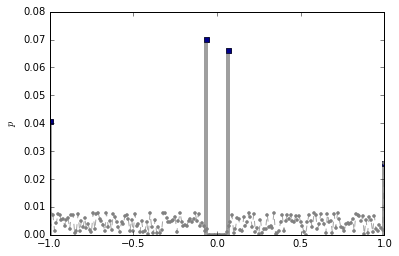

In [10]:
def setup_belief_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.axhline(0.0)
    ax.set_ylabel(r"$p$")
    return ax

ax = setup_belief_plot()
b = Belief()
b.something()
b.plot(ax);

In [11]:
 b.metric_mean()

-0.017596510139533415

In [12]:
def ideally_identity(xd):
    # interpolate a continuous point onto the metric part
    # convert to a distribution over the metric states (a Belief)
    # take the mean of the belief
    affine_combo = state_space.interpolate(xd)
    affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
    return Belief.blend(affine_combo).metric_mean()

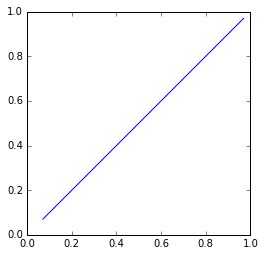

In [13]:
#a sort of unit test. the line should be straight with slope=1
x = np.linspace(0.07,0.97,1000)
y = map(ideally_identity, [(d, -1) for d in x])
plt.plot(x,y)
plt.gca().set_aspect(1.0)

In [14]:
#another sort of unit test
etas = [Belief(delta=s).sum() for s in state_generator(state_space)]

if not np.all([np.isclose(eta, 1.0) for eta in etas]):
    print("Test Fail")

    for s in state_generator(state_space):
        if not np.isclose(Belief(delta=s).sum(), 1.0):
            print(s)

In [15]:
b = Belief(delta=State( DirectionStateFactor(1), ContactStateFactor()))

for s in state_generator(state_space):
    if b.prob(s) != 0:
        print(s, b.prob(s))

(State: +Contact, 1.0)


In [16]:
b = Belief()
b.p[State(DirectionStateFactor(1),ContactStateFactor())] = 1

In [17]:
for s in state_generator(state_space):
    if b.prob(s) != 0:
        print(s, b.prob(s))

(State: +Contact, 1)


In [18]:
class Action(object):
    pass


class GuardedVelocity(Action):
    def __init__(self, velocity):
        self.velocity = velocity
        #self.time_left = 1.0
        #self.finished = False

    def propogate_belief(self, belief, dt=0.1):
        to_blend = []
        for state in state_generator(state_space):
            a = belief.prob(state)
            b = self.propogate_state(state, dt)
            to_blend.append( (a, b) )
        
        return Belief.blend(to_blend)

    def propogate_state(self, state, dt=0.1):
        if isinstance(state.displacement, MetricStateFactor):
            x = state_space.to_continuous(state)[0]
            xprime = x - dt*self.velocity
            
            # we need to break into cases, because even through the interpolate function 
            # does return contact/void states, we cannot let the jig tunnel through the object.
            side_of_object = np.sign(x)
            object_boundary = state_space.object_half_width * side_of_object
            
            if np.sign(x-object_boundary) == np.sign(xprime-object_boundary):
                # on the same side of the object
                # moving along metric surface. with probability alpha, you are stuck and don't move
                alpha = 0.1
                
                affine_combo = state_space.interpolate((xprime, state.direction.d))
                affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
                b_moved = Belief.blend(affine_combo)
                b_got_stuck = Belief(delta=state)
                
                b = Belief.blend([(alpha, b_got_stuck), 
                                  (1-alpha, b_moved)])
            else:
                # made contact, or got stuck with probability alpha 
                alpha = 0.2
                # TODO this would activate a guard, probably. and the termination condition would be set
                b_contact = Belief(delta=State(state.direction, ContactStateFactor()))
                b_got_stuck = Belief(delta=state)
                b = Belief.blend([(alpha, b_got_stuck), 
                                  (1-alpha, b_contact)])                


        elif isinstance(state.displacement, ContactStateFactor):
            contact_direction = -state.direction.d
            if contact_direction * self.velocity >= 0:
                #pushing into contact, so stay with same contact
                b = Belief(delta=state)
            else:
                #moving away from contact. with probability alpha, stay in contact
                alpha = 0.1
                
                contact_position = state_space.object_half_width * -state.direction.d
                xprime = contact_position - dt*self.velocity
                affine_combo = state_space.interpolate((xprime, state.direction.d))
                affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
                b_metric = Belief.blend(affine_combo)
                b_contact = Belief(delta=state)
                
                b = Belief.blend([  (alpha, b_contact),
                                    (1-alpha, b_metric)])

        elif isinstance(state.displacement, VoidStateFactor):
            void_direction = -state.direction.d
            if void_direction * self.velocity <= 0:
                #going further into void, so stay in same void
                b = Belief(delta=state)
            else:
                #moving toward metric. with probability alpha, stay in the void
                alpha = 0.9
                
                void_fringe = state_space.extent * -void_direction
                xprime = void_fringe - dt*self.velocity
                # make sure you don't tunnel through the object
                side_of_object = np.sign(void_fringe)
                object_boundary = state_space.object_half_width * side_of_object
                stayed_on_same_side = ( np.sign(void_fringe-object_boundary) == np.sign(xprime-object_boundary) )             
                
                if stayed_on_same_side:
                    affine_combo = state_space.interpolate((xprime, state.direction.d))
                    affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
                    b_notvoid = Belief.blend(affine_combo)
                else:
                    b_notvoid = Belief(delta=State(state.direction, ContactStateFactor()))
                    
                b_void = Belief(delta=state)
                b = Belief.blend([  (alpha, b_void),
                                    (1-alpha, b_notvoid)])

        return b
        
        

class Position(Action):
    def __init__(self):
        self.time_left = 1.0

In [19]:
action = GuardedVelocity(0.0005)

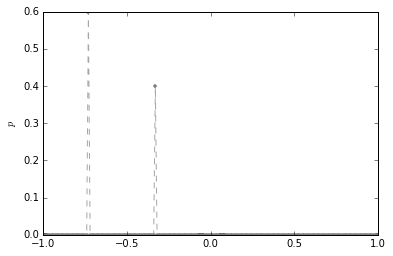

In [20]:
ss = list(state_generator(state_space))

b = Belief.blend([ (0.6, Belief(delta=ss[31])), 
                    (0.4, Belief(delta=ss[71])),])

ax = setup_belief_plot()
b.plot(ax);

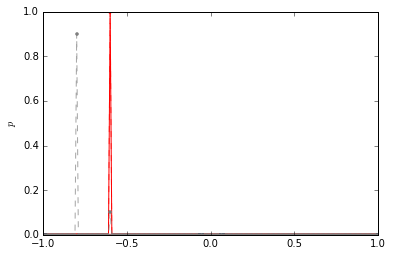

In [21]:
ax = setup_belief_plot()
state = state_space.nearest((-0.6, 1.0))
b = Belief(delta=state)
b.plot(ax, p_metric_kwargs=dict(color='red'))

b1 = GuardedVelocity(0.2).propogate_state(state, dt=1.0)
b1.plot(ax);

try:
    b.metric_mean(), b1.metric_mean()
except ValueError as e:
    print(e)

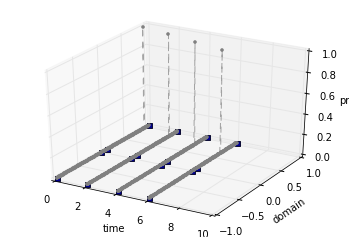

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.set_xlim3d(0, 10)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 1)
ax.set_zlabel("prob")
ax.set_ylabel("domain")
ax.set_xlabel("time")


Belief(delta=state_space.nearest((0.9, -1.0))).plot(ax, all_kwargs=dict(zs=0, zdir="x"));
Belief(delta=state_space.nearest((0.8, -1.0))).plot(ax, all_kwargs=dict(zs=2, zdir="x"));
Belief(delta=state_space.nearest((0.7, -1.0))).plot(ax, all_kwargs=dict(zs=4, zdir="x"));
Belief(delta=state_space.nearest((0.6, -1.0))).plot(ax, all_kwargs=dict(zs=6, zdir="x"));

In [23]:
b.something()

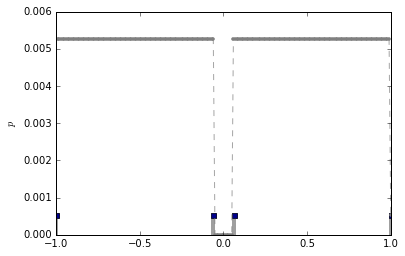

In [24]:
#uniform-ish belief
for s in state_space.manifold_0d:
    b.p[s] = 1.0

for s in state_space.manifold_1d:
    b.p[s] = 10.0

b.normalize()

#b = Belief(delta= state_space.nearest((0.9, -1.0)))

ax = setup_belief_plot()
b.plot(ax);

(0.35050673177911201, -0.010945753982639852)

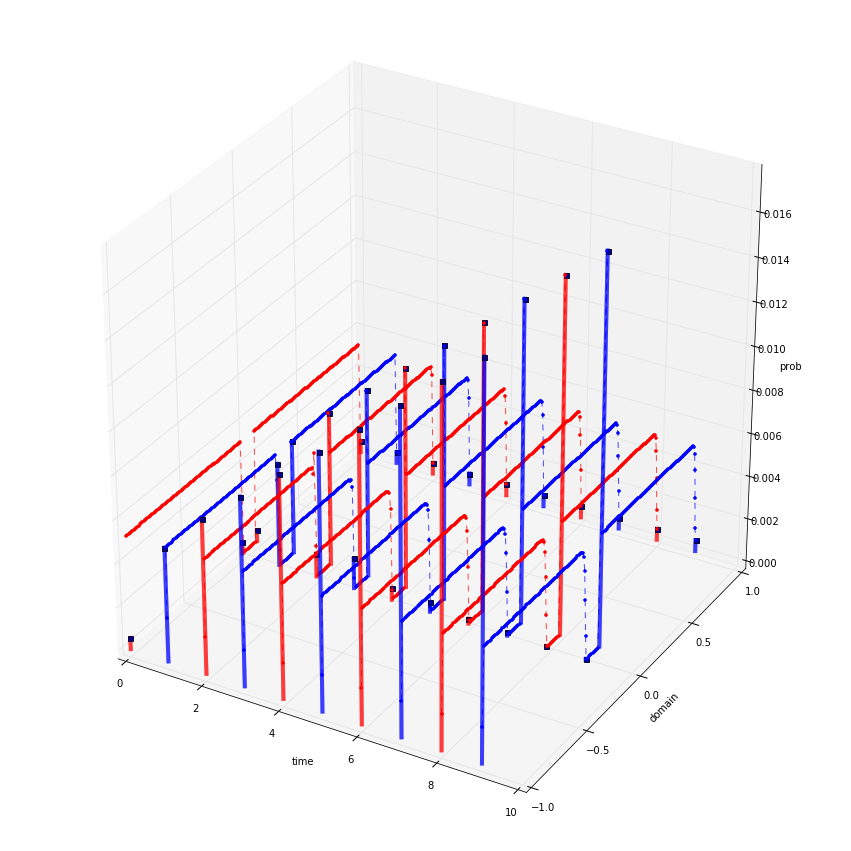

In [25]:
from cycler import cycler

fig = plt.figure()
fig.set_size_inches(15,15)
ax = fig.gca(projection='3d')

ax.set_xlim3d(0, 10)
ax.set_ylim3d(-1, 1)
#ax.set_zlim3d(0, 0.5)
ax.set_zlabel("prob")
ax.set_ylabel("domain")
ax.set_xlabel("time")

zlim = 0.0
for i in range(10):
    b.plot(ax, all_kwargs=dict(zs=i, zdir="x"), p_metric_kwargs=dict(color=['r', 'b'][i%2], linestyle=""));
    zlim = max(zlim, max(b.p.values())) # matplotlib autoscale doesn't work: https://github.com/matplotlib/matplotlib/issues/5742
    b = GuardedVelocity(0.2).propogate_belief(b, dt=0.016)

ax.set_zlim3d(0, zlim)

#ax.set_title("belief in object frame")
#ax.set_xlabel("displacement of jig from object, expressed in object frame")
#ax.semilogy()
b.metric_variance(), b.metric_mean()

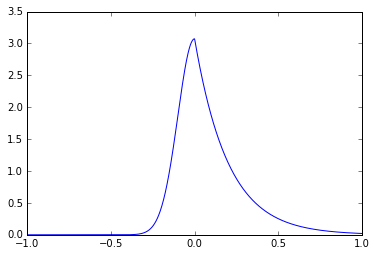

In [26]:
def exp_norm_piecewise(exp_param, norm_param):
    # return a normalized pdf that is continuous at switchpoint
    # it looks like an exponential for positive values
    # it looks like a normal for negative values
    
    def f(x):
        # return np.where(x>=0, np.exp(-x/exp_param), np.exp(-(x**2)/norm_param))
        # the first piece has area s. the second piece has area sqrt(pi)/(2 * sqrt(1/s))
        # where s is, respectively, exp_param and norm_param
        eta = exp_param + np.sqrt(np.pi)/(2*np.sqrt(1.0/norm_param))
        return np.where(x>=0, np.exp(-x/exp_param), np.exp(-(x**2)/norm_param)) / eta
    
    return f

pdf = exp_norm_piecewise(0.2,0.02)
x = np.linspace(-1,1,1000)
y = pdf(x)
plt.plot(x,y)
#plt.gca().semilogy()

In [27]:
import scipy.stats

In [28]:
def displacement_observation_distribution(from_state, to_state):
    # displacement is expressed in the object coordinate frame at 
    # the time of from_state
    #in the 1d case, the object frame doesn't rotate, this is not important?
    
    if from_state.direction != to_state.direction:
        # not too important because the probability of this transition is zero. right?
        # at least in the 1D case.
        return lambda (x): np.zeros_like(x)
        
    from_xd = state_space.to_continuous(from_state) 
    to_xd =  state_space.to_continuous(to_state)
    delta_x = from_xd[0] - to_xd[0]
    
    def not_void(displacement):
        return isinstance(displacement, MetricStateFactor) or isinstance(displacement, ContactStateFactor)
    
    if not_void(from_state.displacement) and not_void(to_state.displacement):
        # if delta_x is positive, that means the jig moved leftward = the object moved rightward
        # this is the nominal observation.
        v = scipy.stats.norm(delta_x, 0.02) #2 cm std. dev
        return lambda (x): v.pdf(x)

    metric_void_trans = None
    if (not_void(from_state.displacement) and 
        isinstance(to_state.displacement, VoidStateFactor)):
        metric_void_trans = 1
    elif (isinstance(from_state.displacement, VoidStateFactor) and 
        not_void(to_state.displacement)):
        metric_void_trans = -1
    
    assert from_state.direction == to_state.direction
    
    if metric_void_trans is not None:
        d = to_xd[1]
        # the object moved, in the from_state.direction.d, at least
        # nominally abs(delta_x). It could be a little less or a lot more.
        def f(x):
            g = exp_norm_piecewise(1.0,0.02)
            return g(metric_void_trans*(x-delta_x)/d)
        return f
    
    if (isinstance(to_state.displacement, VoidStateFactor) and 
        isinstance(from_state.displacement, VoidStateFactor)):
        # doesn't happen in 1D case for now.
        return lambda (x): scipy.stats.norm(0, 10.00).pdf(x) #10 m std. dev
    
    raise ValueError("Need to handle: %s %s"%(from_state, to_state))


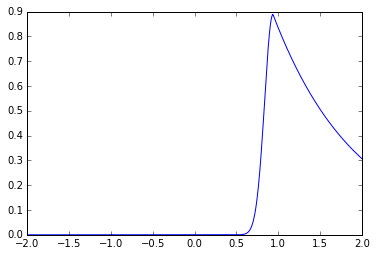

In [29]:
pdf = displacement_observation_distribution(
        State(DirectionStateFactor(-1), VoidStateFactor()),
        State(DirectionStateFactor(-1), ContactStateFactor()))

x = np.linspace(-2,2,1000)
y = pdf(x)
plt.plot(x,y)


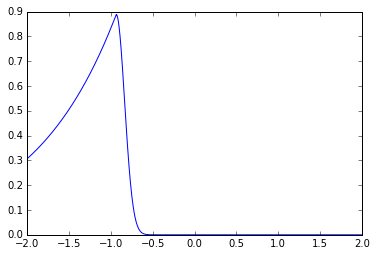

In [30]:
pdf = displacement_observation_distribution(
    State(DirectionStateFactor(1), VoidStateFactor()),
    State(DirectionStateFactor(1), ContactStateFactor()))

x = np.linspace(-2,2,1000)
y = pdf(x)
plt.plot(x,y)


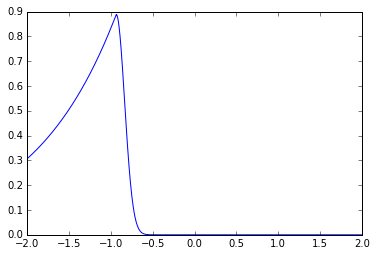

In [31]:
pdf = displacement_observation_distribution(
        State(DirectionStateFactor(-1), ContactStateFactor()),
        State(DirectionStateFactor(-1), VoidStateFactor()))

x = np.linspace(-2,2,1000)
y = pdf(x)
plt.plot(x,y)


True
False


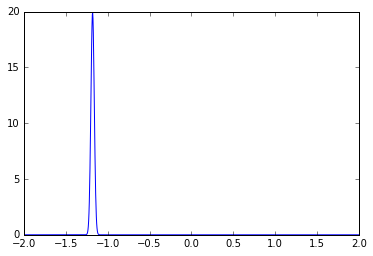

In [32]:
from_state = State(DirectionStateFactor(-1), MetricStateFactor(3))
to_state = State(DirectionStateFactor(-1), MetricStateFactor(110))

print(to_state in state_space.manifold_1d)
print(from_state in state_space.manifold_1d)

pdf = displacement_observation_distribution(from_state, to_state)

x = np.linspace(-2,2,1000)
y = pdf(x)
plt.plot(x,y)


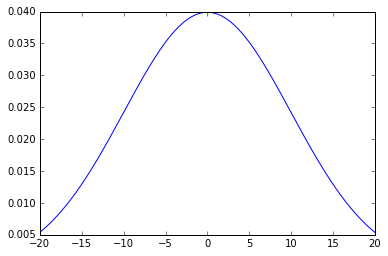

In [33]:
from_state = State(DirectionStateFactor(-1), VoidStateFactor())
to_state = State(DirectionStateFactor(-1), VoidStateFactor())

pdf = displacement_observation_distribution(from_state, to_state)

x = np.linspace(-20,20,1000)
y = pdf(x)
plt.plot(x,y)


In [34]:
def force_observation_distribution(to_state, twist_action):
    # force is expressed in the object coordinate frame at 
    # the time of to_state
    # in the 1d case, the object frame doesn't rotate, this is not important?
    
    if not isinstance(to_state.displacement, ContactStateFactor):
        # not in contact. 
        # assume there's no friction, so nominally there is zero force
        # with friction, would look at the action.
        return lambda (x): scipy.stats.norm(0.0, 0.5).pdf(x) #0.5 N std. dev
    
    else:
        # in a contact state. depending on how we got here, we expect to feel different amounts of force.
        # if we took an action with a force guard with a threshold of t, then we expect that force nominally
        # for now, fix the force threshold.
        # and in the 1D case, we don't have a lot of directions to move in, 
        # so it is not as crucial to look at the action
        
        force_threshold = 5 #Newtons
        
        f = exp_norm_piecewise(5, 3)
        return lambda(x): f(((to_state.direction.d*x)-force_threshold))

    raise ValueError("Need to handle: %s %s"%(twist_action, to_state))


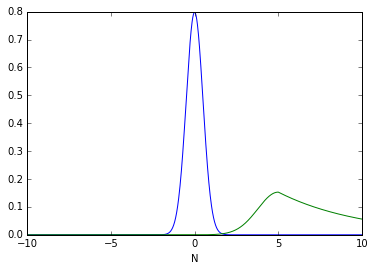

In [35]:
p = force_observation_distribution(State(DirectionStateFactor(1), MetricStateFactor(3)), GuardedVelocity(1.0))

x = np.linspace(-10,10,1000)
y = p(x)
plt.plot(x,y)
plt.xlabel("N")

p = force_observation_distribution(State(DirectionStateFactor(1), ContactStateFactor()), GuardedVelocity(1.0))

x = np.linspace(-10,10,1000)
y = p(x)
plt.plot(x,y)
plt.xlabel("N")

#plt.semilogy()

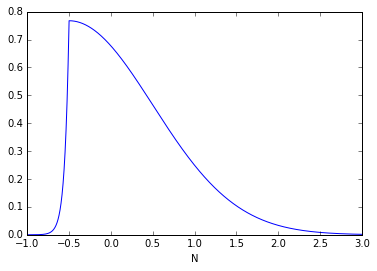

In [36]:
# drag force as you're sliding along a surface, maybe
f = exp_norm_piecewise(0.05, 2.0)
g = lambda(x): f(-(x-(-0.5)))

x = np.linspace(-1,3,1000)
y = g(x)
plt.plot(x,y)
plt.xlabel("N")


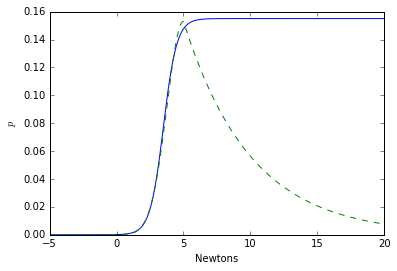

In [37]:
# contact force after going into object
f = exp_norm_piecewise(5, 3)
g = lambda(x): f((x-(5)))

x = np.linspace(-5,20,1000)
y = 0.155 / (1 + np.exp(-2* (x-3.5)))
plt.plot(x,y)
plt.plot(x,g(x),'--')
plt.xlabel("Newtons")
plt.ylabel(r"$p$")

In [38]:
counter_for_things = 0

def distribution_over_next_state_given_sao(state, action, force_observation, displacement_observation, duration, slow=False):
    b = Belief()

    one_step_belief = action.propogate_state(state, dt=duration) # this isn't the prior belief, btw. I don't know a good name.
    for next_state in (state_space.states if slow else one_step_belief.nonzero_states()): #one_step_belief.nonzero_states():
        global counter_for_things
        counter_for_things += 1
        p_d = displacement_observation_distribution(state, next_state)(displacement_observation)
        p_f = force_observation_distribution(next_state, action.velocity)(force_observation)
        p_o = p_d * p_f

        # if p_o were one, then this would be just a transition update
        b[next_state] = p_o * one_step_belief[next_state]
    
    b.normalize()
    
    if np.isnan(b.sum()):
        raise AssertionError((state, action, force_observation, displacement_observation, duration))

    return b
    
def obs_act_update(old_belief, displacement_observation, force_observation, action, duration, slow=False):

    # marginalize out state
    r = Belief.blend(
        [(old_belief[state], 
          distribution_over_next_state_given_sao(state, action, force_observation, displacement_observation, duration, slow))
        for state in old_belief.nonzero_states()])
    
    return r

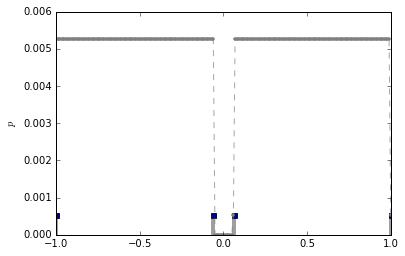

In [39]:
#uniform-ish belief
for s in state_space.manifold_0d:
    b.p[s] = 1.0

for s in state_space.manifold_1d:
    b.p[s] = 10.0

b.normalize()

#b = Belief(delta= state_space.nearest((0.9, -1.0)))

ax = setup_belief_plot()
b.plot(ax);

In [40]:
b1 = obs_act_update(
        b, 
        displacement_observation=0.0,
        force_observation=3.0,
        action=GuardedVelocity(-1.0),
        duration=0.1, slow=False)

In [41]:
b2 = obs_act_update(
        b, 
        displacement_observation=-0.1,
        force_observation=0.0,
        action=GuardedVelocity(-1.0),
        duration=0.1, slow=False)

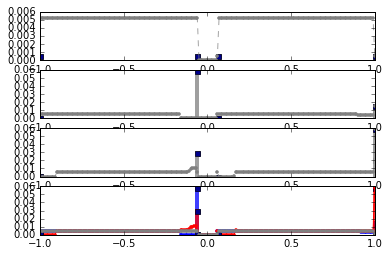

In [51]:
fig = plt.gcf()

for i, _b in enumerate([b, b1, b2]):
    ax = fig.add_subplot(4,1,i+1)
    _b.plot(ax)
    
ax = fig.add_subplot(4,1,4)

b1.plot(ax, p_metric_kwargs=dict(color='blue'));
b2.plot(ax, p_metric_kwargs=dict(color='red'));
b.plot(ax);

In [ ]:
f = displacement_observation_distribution(state, next_state)
x = np.linspace(-10,10,1000)
y = g(x)
plt.plot(x,y)
plt.xlabel("x")

In [ ]:
state, next_state

In [ ]:
%%timeit
x = np.random.rand(200**2,)
y = np.sin(x)